<a href="https://colab.research.google.com/github/singr7/MIRAutoencoder/blob/master/CNNLSTMAutoEncoder_with48bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

#Mount the google drive
#Create list of numpy files for western and indian dataset

In [2]:
import torch
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

western_files = []
western_file_dir = "/content/drive/My Drive/MusicResearchColabNB/MelFeatures/Western_mel_numpy"
for r,d, fileList in os.walk(western_file_dir):
  for file in fileList:
    western_files.append(os.path.join(r,file))

indian_files = []
indian_file_dir = "/content/drive/My Drive/MusicResearchColabNB/MelFeatures/Indian_mel_numpy"
for r,d, fileList in os.walk(indian_file_dir):
  for file in fileList:
    indian_files.append(os.path.join(r,file))

print(len(western_files))
print(len(indian_files))

Mounted at /content/drive
7894
2008


# Balance the western dataset by taking files equal to Indian dataset files = 2008

In [3]:
import random 
#randomize the selection. To avoid getting a different random sample with every run, use seed
random.seed(234)
bal_western_files = random.sample(western_files,2008)
len(bal_western_files)

2008

#Define configuration class

In [4]:
class Configuration:
  seq_len = 200  # taking half of the original timesteps extracted 
  input_dim = 48  #num of mels
  embedding_dim = 64
  batch_size = 2
  base_dir = "/content/drive/My Drive/MusicResearchColabNB/vajra/westernAE_48bins"   # need to be edited..
  loss_function = torch.nn.MSELoss(reduction='sum')
  lr=1e-3  # I edited it from 1e-3 to 1e-5
  n_epochs = 4
  model_file = "/content/drive/My Drive/MusicResearchColabNB/vajra/westernAE_48bins/models/mel.pkl"  #need need edits
  results_dir = os.path.join(base_dir, "./results")  # may need edits
  checkpoint_model_file = "/content/drive/My Drive/MusicResearchColabNB/vajra/westernAE_48bins/models/mel_checkpoint.pkl" #may need edits
  kernel_size = 3  #why?
  k_folds = 10 

In [5]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=3, stride=1):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size,stride=stride, groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size)/ stride) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    #x = x.reshape((10, self.seq_len, self.n_features))
   # print('In Encoder')
   # print(x.shape)
    x = self.conv(x)
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return x

In [6]:
class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=48):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    #print("in decoder", x.shape)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

In [7]:
class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [8]:
x = torch.randn(10, 48, 400)
print(x.shape)
x = x.permute(0, 2, 1)
print(x.shape)

encoder = Encoder(400, 48, embedding_dim=64, kernel_size=3, stride=1)
encoded = encoder(x)
print(encoded.shape)

decoder = Decoder(400, 64, 48)
decoded = decoder(encoded)
print(decoded.shape)

rae = RecurrentAutoencoder(400, 48, 64)
output = rae(x)

print(output.shape)

torch.Size([10, 48, 400])
torch.Size([10, 400, 48])
torch.Size([10, 400, 64])
torch.Size([10, 400, 48])
torch.Size([10, 400, 48])


In [8]:
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SequentialSampler

class CustomDatasetMel(Dataset):

    def __init__(self, dataList):
        self.data = dataList
        #self.labels = labelList

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        import numpy as np
        fileName = self.data[index]
        
        mel_spect = np.load(fileName)
        data = torch.tensor(mel_spect[:,:200], dtype=torch.float)
        data = data.permute(1, 0)
        #data = torch.unsqueeze(data, dim =0)

        #label = torch.tensor(self.labels[index])
        return data

FOLD 0
--------------------------------
length of of train_loader is 904 & length of traindataset is 2008
length of of test_loader is 101
length of of val_loader is 1004
in training loop, epoch 1, step 0, the loss is 1127942.25
in training loop, epoch 1, step 1, the loss is 1940171.25
in training loop, epoch 1, step 2, the loss is 655565.4375
in training loop, epoch 1, step 3, the loss is 1369605.75
in training loop, epoch 1, step 4, the loss is 2766385.5
in training loop, epoch 1, step 5, the loss is 814949.5
in training loop, epoch 1, step 6, the loss is 1033977.0
in training loop, epoch 1, step 7, the loss is 439433.5
in training loop, epoch 1, step 8, the loss is 748764.4375
in training loop, epoch 1, step 9, the loss is 1541110.625
in training loop, epoch 1, step 10, the loss is 1354556.75
in training loop, epoch 1, step 11, the loss is 595433.5
in training loop, epoch 1, step 12, the loss is 454003.71875
in training loop, epoch 1, step 13, the loss is 482447.09375
in training loo

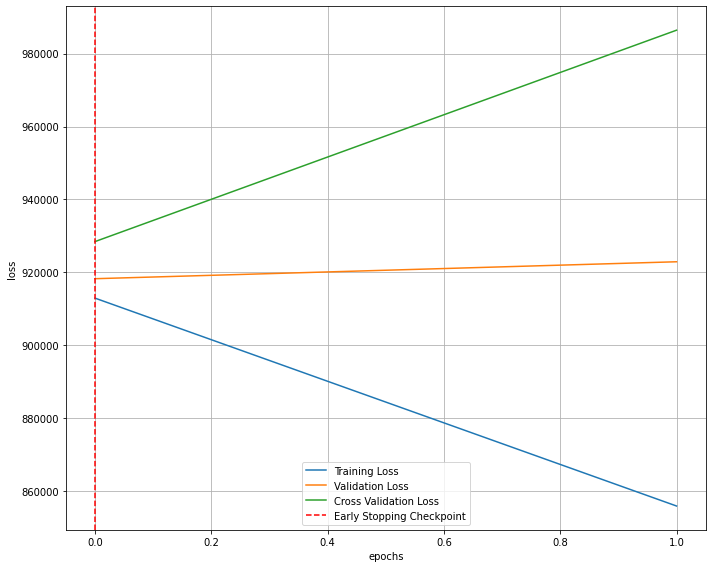

k-fold 0:: Epoch 2: train loss 855889.1073008849 val loss 922907.3384900991
in training loop, epoch 3, step 0, the loss is 648843.75
in training loop, epoch 3, step 1, the loss is 646910.4375
in training loop, epoch 3, step 2, the loss is 620880.125
in training loop, epoch 3, step 3, the loss is 546082.5
in training loop, epoch 3, step 4, the loss is 461157.6875
in training loop, epoch 3, step 5, the loss is 1116210.75
in training loop, epoch 3, step 6, the loss is 691350.75
in training loop, epoch 3, step 7, the loss is 1317974.0
in training loop, epoch 3, step 8, the loss is 710751.5
in training loop, epoch 3, step 9, the loss is 861571.5
in training loop, epoch 3, step 10, the loss is 1076415.5
in training loop, epoch 3, step 11, the loss is 1141832.25
in training loop, epoch 3, step 12, the loss is 929942.0
in training loop, epoch 3, step 13, the loss is 646186.0625
in training loop, epoch 3, step 14, the loss is 764967.5625
in training loop, epoch 3, step 15, the loss is 740230.5


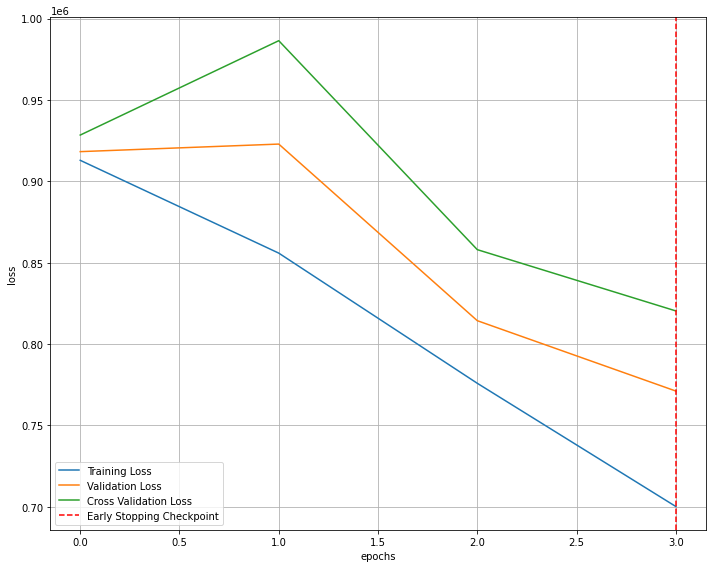

k-fold 0:: Epoch 4: train loss 700152.685546875 val loss 771119.8264232674


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


train_loss_mean_list nan
test_loss_mean_list nan
val_loss_mean_list nan
FOLD 1
--------------------------------
length of of train_loader is 904 & length of traindataset is 2008
length of of test_loader is 101
length of of val_loader is 1004
in training loop, epoch 1, step 0, the loss is 350883.0625
in training loop, epoch 1, step 1, the loss is 799415.75
in training loop, epoch 1, step 2, the loss is 656104.125
in training loop, epoch 1, step 3, the loss is 883751.5625
in training loop, epoch 1, step 4, the loss is 429102.5625
in training loop, epoch 1, step 5, the loss is 589378.5
in training loop, epoch 1, step 6, the loss is 645642.125
in training loop, epoch 1, step 7, the loss is 652300.1875
in training loop, epoch 1, step 8, the loss is 707501.0
in training loop, epoch 1, step 9, the loss is 572348.625
in training loop, epoch 1, step 10, the loss is 347989.71875
in training loop, epoch 1, step 11, the loss is 547670.6875
in training loop, epoch 1, step 12, the loss is 668144.0
i

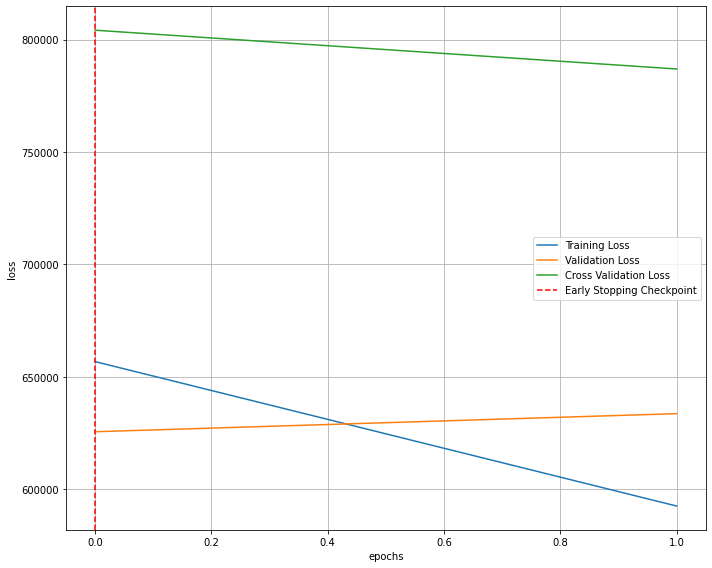

k-fold 1:: Epoch 2: train loss 592511.3346411781 val loss 633601.0683787129
in training loop, epoch 3, step 0, the loss is 462445.6875
in training loop, epoch 3, step 1, the loss is 286580.40625
in training loop, epoch 3, step 2, the loss is 521788.40625
in training loop, epoch 3, step 3, the loss is 583558.5625
in training loop, epoch 3, step 4, the loss is 583119.6875
in training loop, epoch 3, step 5, the loss is 489371.125
in training loop, epoch 3, step 6, the loss is 318621.5625
in training loop, epoch 3, step 7, the loss is 780860.6875
in training loop, epoch 3, step 8, the loss is 446409.875
in training loop, epoch 3, step 9, the loss is 404184.34375
in training loop, epoch 3, step 10, the loss is 574782.8125
in training loop, epoch 3, step 11, the loss is 320706.71875
in training loop, epoch 3, step 12, the loss is 336216.40625
in training loop, epoch 3, step 13, the loss is 380903.1875
in training loop, epoch 3, step 14, the loss is 696485.375
in training loop, epoch 3, step 

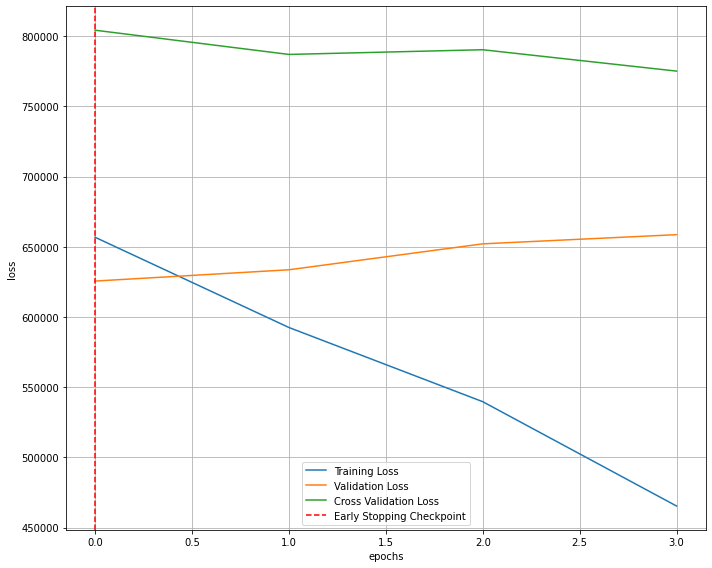

k-fold 1:: Epoch 4: train loss 465371.5586628872 val loss 658607.5259900991


AxisError: ignored

In [23]:
import copy
import math
import numpy as np

import torch

class TrainingWrapper:

  def __init__(self, config, training_loader, test_loader, device, val_loader=None, cross=10):
    self.config = config
    self.training_loader = training_loader
    self.test_loader = test_loader
    self.val_loader = val_loader
    self.device = device
    self.model = RecurrentAutoencoder(self.config.seq_len, self.config.input_dim, self.config.embedding_dim, device=self.device)
    self.model = self.model.to(self.device)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.lr)
    self.criterion = self.config.loss_function.to(self.device)
    self.history = dict(train=[], val=[], cross_val=[])
    self.best_model_wts = copy.deepcopy(self.model.state_dict())
    self.best_loss = 10000.0
    #print(self.config.base_dir + self.config.model_file)
    torch.save(self.model.state_dict(),  self.config.model_file)
    self.cross = cross
    

  def combine_images(self, generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image


  def show_reconstruction(self, test_loader, n_images):
    import matplotlib.pyplot as plt
    
    from PIL import Image
    import numpy as np

    self.model.eval()
    for x, _ in self.test_loader:
        x = x[:min(n_images, x.size(0))].to(self,device)
        _, x_recon = self.model(x)
        data = np.concatenate([x.data.cpu(), x_recon.data.cpu()])
        img = self.combine_images(np.transpose(data, [0, 2, 3, 1]))
        image = img * 255
        Image.fromarray(image.astype(np.uint8)).save(self.config.base_dir + "/real_and_recon.png")
        print()
        print('Reconstructed images are saved to %s/real_and_recon.png' % self.config.base_dir)
        print('-' * 70)
        plt.imshow(plt.imread(self.config.base_dir + "/real_and_recon.png", ))
        plt.show()
        break

  def visualizeTraining(self, epoch, trn_losses, tst_losses, val_losses, save_dir,cross):
    # visualize the loss as the network trained
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(0, len(trn_losses)), trn_losses, label='Training Loss')
    if tst_losses:
      plt.plot(range(0, len(tst_losses)), tst_losses, label='Validation Loss')
    if val_losses:
      plt.plot(range(0, len(val_losses)), val_losses, label='Cross Validation Loss')

    minposs = tst_losses.index(min(tst_losses))
    plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')


    plt.xlabel('epochs')
    plt.ylabel('loss')
    # plt.ylim(0, 0.5)  # consistent scale
    # plt.xlim(0, len(trn_losses))  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(save_dir , 'loss_plot_{}.png'.format(cross)), bbox_inches='tight')

  def train(self):
    self.model.load_state_dict(torch.load(config.checkpoint_model_file))
    for epoch in range(1, self.config.n_epochs + 1):
      self.model = self.model.train()
      train_losses = []
      for i, data in enumerate(self.training_loader,0):
        x = data
        self.optimizer.zero_grad()
        x = x.to(self.device)

        output = self.model(x)
        loss = self.criterion(output, x)

        loss.backward()
        self.optimizer.step()
        train_losses.append(loss.item())
        print("in training loop, epoch {}, step {}, the loss is {}".format(epoch, i, loss.item()))

      val_losses = []
      self.model = self.model.eval()
      with torch.no_grad():
        for i, data in enumerate(self.test_loader):
          x = data
          x = x.to(device)
          output = self.model(x)
          loss = self.criterion(output, x)
          val_losses.append(loss.item())


      cross_val_losses = []
      self.model = self.model.eval()
      with torch.no_grad():
        for i, data in enumerate(self.val_loader):
          x = data
          x = x.to(device)
          output = self.model(x)
          loss = self.criterion(output, x)
          cross_val_losses.append(loss.item())

      train_loss = np.mean(train_losses)
      val_loss = np.mean(val_losses)
      cross_val_loss = np.mean(cross_val_losses)


      self.history['train'].append(train_loss)
      self.history['val'].append(val_loss)
      self.history['cross_val'].append(cross_val_loss)

      if val_loss < self.best_loss:
        self.best_loss = val_loss
        self.best_model_wts = copy.deepcopy(self.model.state_dict())
      torch.save(self.model.state_dict(),  self.config.checkpoint_model_file)
      if epoch % 2 == 0:
        self.visualizeTraining(epoch, trn_losses= self.history['train'], tst_losses=self.history['val'], val_losses =self.history['cross_val'], save_dir=self.config.base_dir + "/results",cross=fold)
      print(f'k-fold {fold}:: Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    self.model.load_state_dict(self.best_model_wts)
    torch.save(self.model.state_dict(), self.config.model_file)
    return self.model.eval(), self.history

  
class TestingWrapper:
  def __init__(self, config, device):
    self.config = config
    self.device = device
    self.model = RecurrentAutoencoder(self.config.seq_len, self.config.input_dim, self.config.embedding_dim, device=self.device)
    PATH =  self.config.checkpoint_model_file
    print(PATH)
    self.model.load_state_dict(torch.load(PATH, map_location=self.device))
    self.model = self.model.to(self.device)

  def combine_images(self, generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image


  def show_reconstruction(self, test_loader, n_images):
    import matplotlib.pyplot as plt
    
    from PIL import Image
    import numpy as np

    self.model.eval()
    for x, _ in test_loader:
      x = x[:min(n_images, x.size(0))].to(self.device)
      x_recon = self.model(x)
      data = np.concatenate([x.data.cpu(), x_recon.data.cpu()])
      img = self.combine_images(np.transpose(data, [0, 2, 3, 1]))
      image = img * 255
      Image.fromarray(image.astype(np.uint8)).save(self.config.base_dir + "/real_and_recon.png")
      print()
      print('Reconstructed images are saved to %s/real_and_recon.png' % self.config.base_dir)
      print('-' * 70)
      plt.imshow(plt.imread(self.config.base_dir + "/real_and_recon.png", ))
      plt.show()
      break

  def save_reconstruction(self, test_loader):
    import matplotlib.pyplot as plt
    
    from PIL import Image
    import numpy as np
    import uuid


    self.model.eval()
    with torch.no_grad(): 
      fileCount = 0
      for x, _ in test_loader:
        x = x.to(self.device)
        x_recon = self.model(x)
        x_recon = x_recon.data.cpu().detach().numpy()
        for mel in x_recon:
          #print(mel.shape)
          unique_filename = str(uuid.uuid4())
          filename = self.config.base_dir + "/reconstruction/" + unique_filename + ".npy"
          np.save(filename, mel)
          fileCount = fileCount + 1
          print("saving file {} at index {}".format(filename, fileCount))

mode = 'train'
data = "mel"
#data = "mnist"
config = Configuration()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import random
import os

def seed_everything(seed=1234):
  
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True

def visualizeTraining(epoch, trn_losses, tst_losses, val_losses, save_dir):
    # visualize the loss as the network trained
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(0, len(trn_losses)), trn_losses, label='Training Loss')
    #if tst_losses:
    plt.plot(range(0, len(tst_losses)), tst_losses, label='Validation Loss')
    #if val_losses:
    plt.plot(range(0, len(val_losses)), val_losses, label='Cross Validation Loss')

    #minposs = tst_losses.index(min(tst_losses))
    #plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')


    plt.xlabel('epochs')
    plt.ylabel('loss')
    # plt.ylim(0, 0.5)  # consistent scale
    # plt.xlim(0, len(trn_losses))  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(save_dir , 'loss_plot_{}.png'.format("MEAN")), bbox_inches='tight')

seed_everything()

train_data = bal_western_files
#labels = [1] * len(bal_western_files)

val_data = indian_files
#val_labels = [1] * len(indian_files)

train_loss_mean_list = []
test_loss_mean_list = []
val_loss_mean_list = []

# Cross validation runs
# use sklearn KFolds
from sklearn.model_selection import KFold
kfold = KFold(n_splits=config.k_folds , shuffle=True)

train_dataset = CustomDatasetMel(train_data)
val_dataset = CustomDatasetMel(val_data)
#Load the cross val dataset which is Full Indian dataset
#It is identical for all K-folds
crossval_loader = torch.utils.data.DataLoader(
                      val_dataset,
                      batch_size=config.batch_size, 
                      sampler=SequentialSampler(val_dataset), 
                      drop_last=False)  

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
    # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
    # Define data loaders for training and testing data in this fold
  train_loader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=config.batch_size,
                      sampler=train_subsampler,
                      drop_last=False)
  test_loader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=config.batch_size,
                      sampler=test_subsampler,
                      drop_last=False)
    
  print("length of of train_loader is {} & length of traindataset is {}".format(len(train_loader),len(train_dataset)))
  print("length of of test_loader is {}".format(len(test_loader)))
  print("length of of val_loader is {}".format(len(crossval_loader)))
    
  if mode=="train":
    trainingWrapper = TrainingWrapper(config=config, training_loader=train_loader, test_loader=test_loader, device=device, val_loader=crossval_loader, cross=fold)
    model, history = trainingWrapper.train()
    np.append(train_loss_mean_list,history['train'])
    np.append(test_loss_mean_list,history['val'])
    np.append(val_loss_mean_list,history['cross_val'])
    

    if data=="mnist":
      #trainingWrapper.show_reconstruction(test_loader=test_loader, n_images=50)
      pass

  elif mode=="test":
    testWrapper = TestingWrapper(config=config, device=device)
    testWrapper.save_reconstruction(test_loader)
  
  train_loss_mean_list = np.mean(train_loss_mean_list, axis=0)
  test_loss_mean_list = np.mean(test_loss_mean_list, axis=0)
  val_loss_mean_list = np.mean(val_loss_mean_list, axis=0)
  print("train_loss_mean_list",train_loss_mean_list)
  print("test_loss_mean_list",test_loss_mean_list)
  print("val_loss_mean_list",val_loss_mean_list)
  #visualizeTraining(0, train_loss_mean_list, test_loss_mean_list, val_loss_mean_list, save_dir = config.base_dir + "/results")

  

In [22]:
a=[1,2]
b= np.mean(a,axis=0)
c= b.tolist()
c

1.5